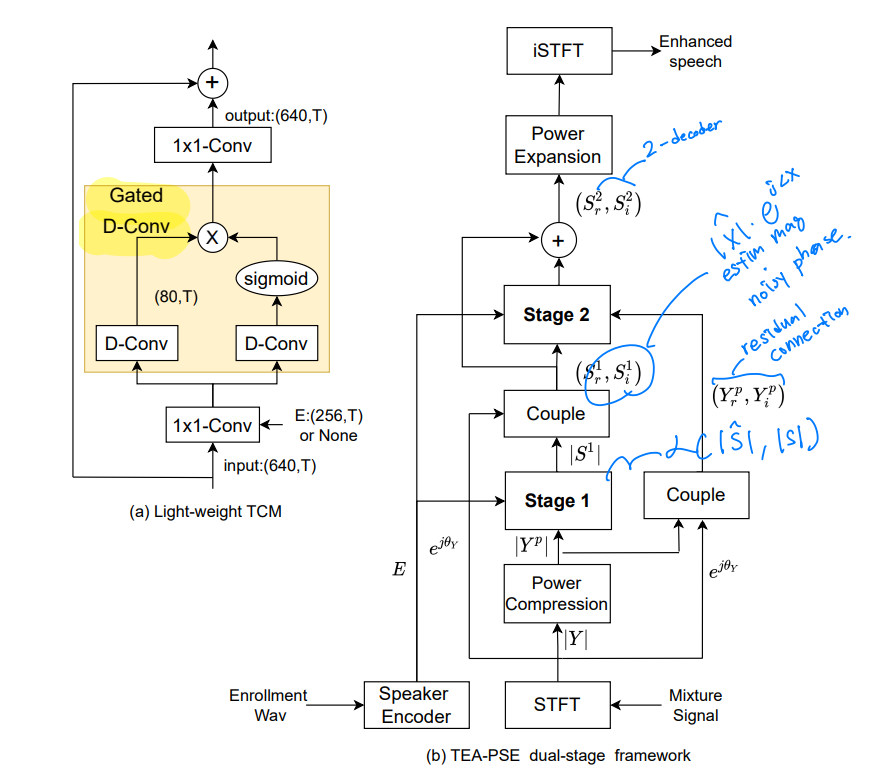

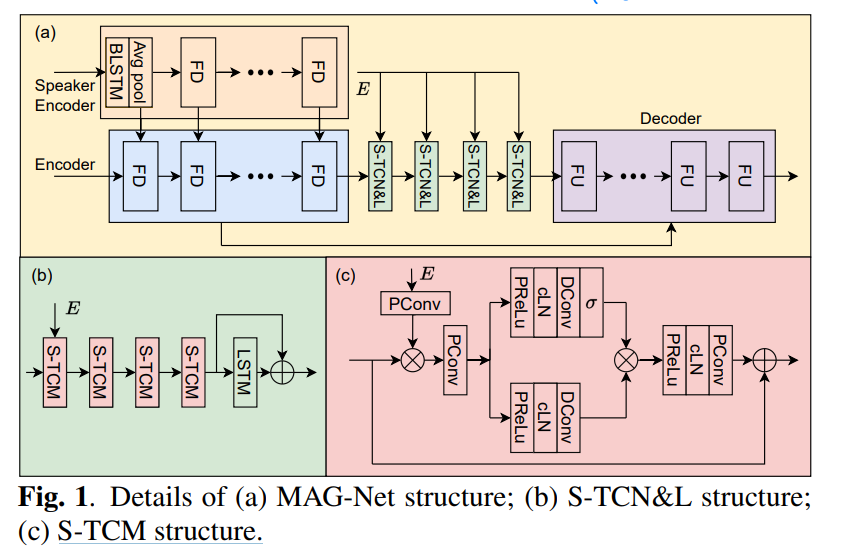

In [1]:
import torch
import torch.nn as nn

/home/kbh/.conda/envs/dnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# https://wdprogrammer.tistory.com/71
# Gate Convolution Layer
class GConv(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size, stride=1, padding=0,  groups=1):
        super(GConv,self).__init__()
        
        self.c = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding,  groups=groups)
        self.m = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding,  groups=groups),
            nn.Sigmoid()
            )
        
    def forward(self, x): 
        m = self.m(x)
        x = self.c(x)
        
        return m*x
                
class TrGConv(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1):
        super(TrGConv,self).__init__()
        
        self.c = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding, groups=groups)
        self.m = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding, groups=groups),
            nn.Sigmoid()
            )
        
    def forward(self, x): 
        m = self.m(x)
        x = self.c(x)
        
        return m*x 

IEEE/ACM TRANSACTIONS ON AUDIO, SPEECH, AND LANGUAGE PROCESSING, VOL. 29, 2021 1829
Two Heads are Better Than One: A Two-Stage
Complex Spectral Mapping Approach for Monaural
Speech Enhancement
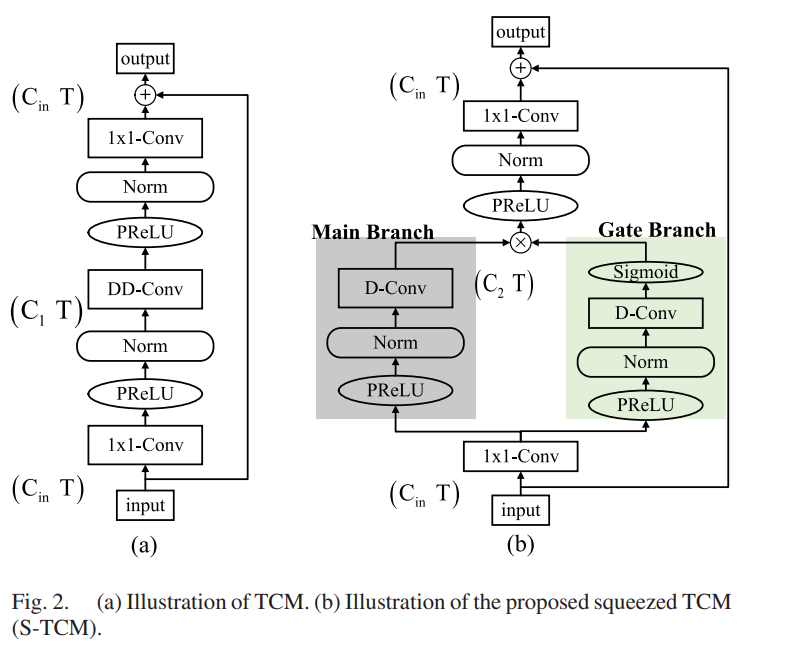

In [87]:
# Squeezed Temporal convolution module
class S_TCM(nn.Module):
    def __init__(self,in_channels, out_channels, squeezed_channels, dilation=1):
        super(S_TCM,self).__init__()
        
        act = nn.PReLU
        norm = nn.BatchNorm1d
        
        self.pre = nn.Sequential(
            nn.Conv1d(in_channels,squeezed_channels,1)
        )
        
        self.conv = nn.Sequential(
            act(),
            norm(squeezed_channels),
            nn.Conv1d(squeezed_channels,squeezed_channels,5,dilation=dilation,padding=dilation*2)
        )
            
        self.mask = nn.Sequential(
            act(),
            norm(squeezed_channels),
            nn.Conv1d(squeezed_channels,squeezed_channels,5,dilation=dilation,padding=dilation*2),        
            nn.Sigmoid()
        )
       
        self.post = nn.Sequential(
            act(),
            norm(squeezed_channels),
            nn.Conv1d(squeezed_channels,out_channels,1)
        )
    
    def forward(self,x):
        # x : [B, c_in,T]
    
        # into squeezed channel
        # y : [B, c_squeezed,T]
        y = self.pre(x)
        
        m = self.mask(y)
        y = self.conv(y)
        
        # restoration from squeezed channel
        y = self.post(m*y)
        
        print(x.shape)
        print(y.shape)
        
        y = x + y
        # y : [B, c_out,T]
        print("TCM : {}".format(x.shape))
        return y

## cumulative Layer Normalization

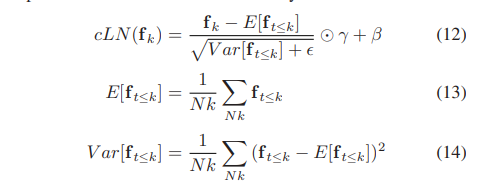

In [88]:
class S_TCNnL(nn.Module):
    def __init__(self,in_channels, squeezed_channels, hidden_size = 512):
        super(S_TCNnL,self).__init__()
        
        self.net = nn.Sequential(
            S_TCM(in_channels, in_channels, squeezed_channels = 64, dilation=1),
            S_TCM(in_channels, in_channels, squeezed_channels = 64, dilation=2),
            S_TCM(in_channels, in_channels, squeezed_channels = 64, dilation=5),
            S_TCM(in_channels, in_channels, squeezed_channels = 64, dilation=9)
        )
        
        self.rnn = nn.LSTM(in_channels, hidden_size,batch_first = True)
    
    def forward(self,x):
        # x : [B, C_in, T]
        
        y1 = self.net(x)
        
        # x -> [B, T, C_in]
        y1 = torch.permute(x,(0,2,1))
        y2,h = self.rnn(y1)
        
        y = y1 + y2
        
        y = torch.permute(y,(0,2,1))
        # y : [B, C_in, T]
        return y
        

In [89]:
architecture = {
    "FD": {
        "fd0":{"in_channels": 1, "out_channels": 64, "kernel_size": [3, 2], "stride": [2,1]},
        "fd1":{"in_channels": 64, "out_channels": 64, "kernel_size": [3, 2], "stride": [2,1]},
        "fd2":{"in_channels": 64, "out_channels": 64, "kernel_size": [3, 2], "stride": [2,1]},
        "fd3":{"in_channels": 64, "out_channels": 64, "kernel_size": [3, 2], "stride": [2,1]},
        "fd4":{"in_channels": 64, "out_channels": 64, "kernel_size": [3, 2], "stride": [2,1]},
        "fd5":{"in_channels": 64, "out_channels": 64, "kernel_size": [3, 2], "stride": [2,1]},
    },
    "BTN":{"in_channels": 448, "squeezed_channels":64, "hidden_size":512 },
    "FU": {
         "fu5":{"in_channels": 64, "out_channels": 64, "kernel_size": [3, 2], "stride": [2,1]},
         "fu4":{"in_channels": 64, "out_channels": 64, "kernel_size": [3, 2], "stride": [2,1]},
         "fu3":{"in_channels": 64, "out_channels": 64, "kernel_size": [3, 2], "stride": [2,1]},
         "fu2":{"in_channels": 64, "out_channels": 64, "kernel_size": [3, 2], "stride": [2,1]},
         "fu1":{"in_channels": 64, "out_channels": 64, "kernel_size": [3, 2], "stride": [2,1], "output_padding" : [1,0]},
         "fu0":{"in_channels": 64, "out_channels": 1, "kernel_size": [3, 2], "stride": [2,1], "output_padding" : [1,0]}
    }
}

class FD(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size, stride=1, padding=0,  groups=1):
        super(FD,self).__init__()
        
        self.c = GConv(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding,  groups=groups)
        
        # Suppose be cumulative Layer Normalization
        self.n = nn.BatchNorm2d(out_channels)
        self.a = nn.PReLU()
        
    def forward(self, x): 
        y = self.c(x)
        y = self.n(y)
        y = self.a(y)
        return y
        
        
class FU(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1):
        super(FU,self).__init__()
        
        self.c = TrGConv(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding, groups=groups)
        # Suppose be cumulative Layer Normalization
        self.n = nn.BatchNorm2d(out_channels)
        self.a = nn.PReLU()
        
    def forward(self, x): 
        y = self.c(x)
        y = self.n(y)
        y = self.a(y)
        
        return y       
        
class TEAPSE(nn.Module):
    def __init__(self,architecture=architecture):
        super(TEAPSE,self).__init__()
        
        ## Freq-Down
        self.fd = []
        self.n_fd = len(architecture["FD"])
        for i in range(self.n_fd) : 
            module  = FD(**architecture["FD"]["fd{}".format(i)])
            self.add_module("fd{}".format(i),module)
            self.fd.append(module)
            
        self.fd = nn.ModuleList(self.fd)
        
        # Bottleneck
        self.BTN = S_TCNnL(**architecture["BTN"])
        
        # Freq-Up
        self.fu = []
        self.n_fu = len(architecture["FU"])
        for i in range(self.n_fu) : 
            module  = FU(**architecture["FU"]["fu{}".format(self.n_fu -i -1)])
            self.add_module("fu{}".format(self.n_fu -i -1),module)
            self.fu.append(module)
            
        self.fd = nn.ModuleList(self.fd)
        
    def forward(self,x):
        skip = []
        for i in range(self.n_fd):
            x = self.fd[i](x)
            print("fd{} : {}".format(i,x.shape))
            skip.append(x)
        
        B,C,F,T = x.shape
        x = torch.reshape(x,(B,C*F,T))
        x = self.BTN(x)
        x = torch.reshape(x,(B,C,F,T))
            
        for i in range(self.n_fu):
            x = x + skip[self.n_fu -i -1]
            x = self.fu[i](x)
            print("fd{} + {} : {}".format(self.n_fu -i -1,skip[self.n_fu -i -1].shape,x.shape))
            
        return x
    
B = 2
C = 1
F = 514
T = 30
x = torch.rand(B,C,F,T)
print(x.shape)
m = TEAPSE()

y = m(x)

print(y.shape)

torch.Size([2, 1, 514, 30])
fd0 : torch.Size([2, 64, 256, 29])
fd1 : torch.Size([2, 64, 127, 28])
fd2 : torch.Size([2, 64, 63, 27])
fd3 : torch.Size([2, 64, 31, 26])
fd4 : torch.Size([2, 64, 15, 25])
fd5 : torch.Size([2, 64, 7, 24])
torch.Size([2, 448, 24])
torch.Size([2, 448, 24])
TCM : torch.Size([2, 448, 24])
torch.Size([2, 448, 24])
torch.Size([2, 448, 24])
TCM : torch.Size([2, 448, 24])
torch.Size([2, 448, 24])
torch.Size([2, 448, 24])
TCM : torch.Size([2, 448, 24])
torch.Size([2, 448, 24])
torch.Size([2, 448, 24])
TCM : torch.Size([2, 448, 24])


RuntimeError: The size of tensor a (448) must match the size of tensor b (512) at non-singleton dimension 2